In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# ----------------------------------
# Parameter Specification
# ----------------------------------
n_inp = 2
n_out = 1
n_hid = 20
activ_h = lambda x: tf.nn.relu(x)
activ_o = lambda x: tf.sigmoid(x)
var_init = 0.1
learn_r = 0.01
n_epoch = 2000
batch_size = 100
# number of samples for one label
n_train = 1500
n_val, n_test = 150, 200


In [3]:
# ----------------------------------
# Data Generation
# ----------------------------------
def create_0(num):  # class 0
    r = np.random.normal(0, 1, num)
    t = np.random.uniform(0, 2*np.pi, num)
    data = np.stack([r*np.cos(t), r*np.sin(t)],axis=1)
    return data

def create_1(num):  # class 1
    r = np.random.normal(0, 1, num)
    t = np.random.uniform(0, 2*np.pi, num)
    data = np.stack([(5+r)*np.cos(t), (5+r)*np.sin(t)], axis=1)
    return data

train_set = np.concatenate([create_0(n_train), create_1(n_train)], axis=0)  #  [2*n_train x n_inp]
label = np.zeros((n_train*2,1), np.int32)
label[n_train:] += 1
train_set = np.concatenate([train_set, label], axis=1)

val_set = np.concatenate([create_0(n_val), create_1(n_val)], axis=0)
label = np.zeros((n_val*2,1), np.int32)
label[n_val:] += 1
val_set = np.concatenate([val_set, label], axis=1)

test_set = np.concatenate([create_0(n_test), create_1(n_test)], axis=0)
label = np.zeros((n_test*2,1), np.int32)
label[n_test:] += 1
test_set = np.concatenate([test_set, label], axis=1)

# Print train/valid/test datasets

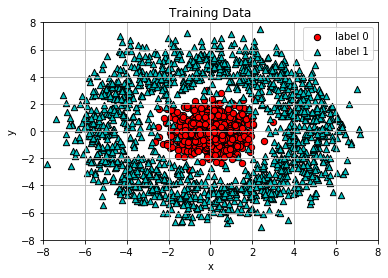

In [4]:
plt.title("Training Data")
plt.xlabel('x')
plt.scatter(train_set[:n_train,0], train_set[:n_train,1], \
            c='r', edgecolor='k', s=40, label='label 0')
plt.scatter(train_set[n_train:,0], train_set[n_train:,1], \
            marker='^', c='c', edgecolor='k', s=40, label='label 1')
plt.axis([-8,8,-8,8])
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True)
plt.show()

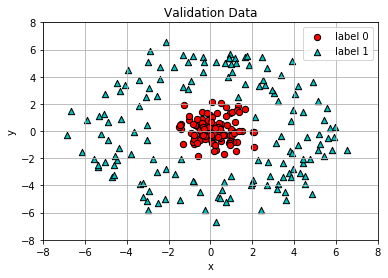

In [5]:
plt.title("Validation Data")
plt.xlabel('x')
plt.scatter(val_set[:n_val,0], val_set[:n_val,1], c='r',\
            edgecolor='k', s=40, label='label 0')
plt.scatter(val_set[n_val:,0], val_set[n_val:,1], marker='^',\
            c='c', edgecolor='k', s=40, label='label 1')
plt.axis([-8,8,-8,8])
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True)
plt.show()

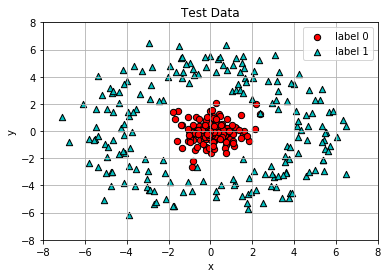

In [6]:
plt.title("Test Data")
plt.xlabel('x')
plt.scatter(test_set[:n_test,0], test_set[:n_test,1], \
            c='r', edgecolor='k', s=40, label='label 0')
plt.scatter(test_set[n_test:,0], test_set[n_test:,1], \
            marker='^', c='c', edgecolor='k', s=40, label='label 1')
plt.axis([-8,8,-8,8])
plt.ylabel('y')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Computational graph

In [7]:
# ----------------------------------
# Symbolic variables for input
# ----------------------------------
x_ = tf.placeholder(tf.float32, [None, n_inp])
y_ = tf.placeholder(tf.float32, [None, n_out])
keep_prob = tf.placeholder(tf.float32)
lr = tf.placeholder(tf.float32, shape=[])

# ----------------------------------
# Fully connected layers 
# ----------------------------------
W_fc1 = tf.Variable(tf.truncated_normal([n_inp, n_hid], stddev=var_init)) 
b_fc1 = tf.Variable(tf.truncated_normal([n_hid], stddev=var_init))
h_1 = tf.matmul(x_, W_fc1) + b_fc1
h_1a = activ_h(h_1)
h_1a_drop = tf.nn.dropout(h_1a, keep_prob)

W_fc2 = tf.Variable(tf.truncated_normal([n_hid, n_out], stddev=var_init)) 
b_fc2 = tf.Variable(tf.truncated_normal([n_out], stddev=var_init))
logits = tf.matmul(h_1a_drop, W_fc2) + b_fc2
y_hat = activ_o(logits)

l2_norm = 0.001* tf.reduce_mean([ tf.reduce_mean(tf.nn.l2_loss(W_fc1)+\
                                                 tf.nn.l2_loss(W_fc2))])

# ----------------------------------
# Cross-entropy cost function
# ----------------------------------

ce = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits\
                   (logits=logits, labels=y_))+ l2_norm 
train_step = tf.train.AdamOptimizer(lr).minimize(ce + l2_norm)
correct_prediction = tf.cast(tf.equal(tf.cast(y_, tf.int32), \
            tf.cast(tf.greater_equal(y_hat, 0.5), tf.int32)), tf.int32)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# Training

In [9]:
# ----------------------------------
# Run Optimization
# ----------------------------------
t_ce = []
v_ce = []
print("=================================")
print("|Epoch\t|Train\t|Val\t|")
print("|===============================|")
for epoch in range(n_epoch):
    np.random.shuffle(train_set)
    np.random.shuffle(val_set)
    train_step.run(feed_dict={x_: train_set[:,:2], y_: train_set[:,2:3], \
                              keep_prob:0.8, lr: learn_r})
    if epoch%50 == 49:
        train_accuracy, train_loss = sess.run([accuracy, ce],feed_dict={\
                    x_: train_set[:,:2], y_: train_set[:,2:3], keep_prob:1.0})
        val_accuracy, val_loss = sess.run([accuracy, ce], feed_dict={\
                        x_: val_set[:,:2], y_: val_set[:,2:3], keep_prob:1.0})
        t_ce += [train_loss/n_train]
        v_ce += [val_loss/n_val]
        print("|%d\t|%.4f\t|%.4f\t|"%(epoch+1, train_accuracy, val_accuracy))
print("|===============================|")

test_accuracy = accuracy.eval(feed_dict={x_: test_set[:,:2], y_: test_set[:,2:3],\
                                         keep_prob:1.0})
print("test accuracy=%.4f"%(test_accuracy))


|Epoch	|Train	|Val	|
|===============================|
|50	|0.9873	|0.9833	|
|100	|0.9897	|0.9967	|
|150	|0.9910	|0.9967	|
|200	|0.9907	|0.9967	|
|250	|0.9903	|0.9967	|
|300	|0.9900	|0.9933	|
|350	|0.9900	|0.9933	|
|400	|0.9903	|0.9967	|
|450	|0.9910	|0.9933	|
|500	|0.9910	|0.9967	|
|550	|0.9910	|0.9933	|
|600	|0.9913	|0.9967	|
|650	|0.9917	|0.9933	|
|700	|0.9903	|0.9967	|
|750	|0.9903	|0.9933	|
|800	|0.9913	|0.9933	|
|850	|0.9907	|0.9933	|
|900	|0.9907	|0.9967	|
|950	|0.9913	|0.9933	|
|1000	|0.9913	|0.9933	|
|1050	|0.9910	|0.9967	|
|1100	|0.9910	|0.9933	|
|1150	|0.9910	|0.9933	|
|1200	|0.9910	|0.9933	|
|1250	|0.9910	|0.9933	|
|1300	|0.9907	|0.9933	|
|1350	|0.9913	|0.9933	|
|1400	|0.9907	|0.9967	|
|1450	|0.9913	|0.9933	|
|1500	|0.9913	|0.9967	|
|1550	|0.9910	|0.9933	|
|1600	|0.9907	|0.9967	|
|1650	|0.9910	|0.9933	|
|1700	|0.9913	|0.9933	|
|1750	|0.9910	|0.9933	|
|1800	|0.9910	|0.9933	|
|1850	|0.9907	|0.9933	|
|1900	|0.9910	|0.9933	|
|1950	|0.9910	|0.9933	|
|2000	|0.9910	|0.9933	|
|====

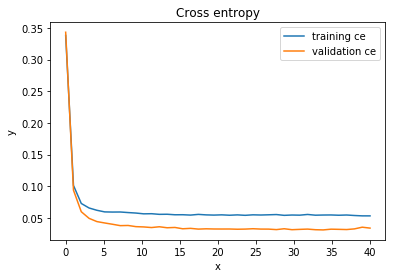

In [10]:
plt.title("Cross entropy")
plt.xlabel('x')
x = np.linspace(0,len(t_ce),num=len(t_ce))
plt.plot(x, t_ce, label='training ce')
plt.plot(x, v_ce, label='validation ce')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

# Trained parameters

In [11]:
print("W_fc1")
print(W_fc1.eval())
print("b_fc1")
print(b_fc1.eval())
print("W_fc2")
print(W_fc2.eval())
print("b_fc2")
print(b_fc2.eval())

W_fc1
[[ -2.78278142e-01   5.39796456e-05   3.59945178e-01   1.00939178e+00
   -4.13012430e-02   9.69308972e-01  -1.14099097e+00  -9.51137066e-01
    9.67757106e-01  -1.91187605e-01  -5.62964082e-01  -1.21464896e+00
    1.27180076e+00   2.14628920e-01  -8.38105679e-02   9.57312167e-01
   -1.28806007e+00  -1.13688576e+00  -5.67637719e-02  -6.84180781e-02]
 [  1.62932086e+00  -1.39116085e-09  -1.28553116e+00   6.02655351e-01
   -1.91561669e-01  -8.84630740e-01  -7.22231328e-01   7.75650620e-01
    7.71807551e-01  -1.34075117e+00  -1.43043327e+00  -2.34473020e-01
   -1.84522253e-02   1.29115260e+00  -1.59229800e-01  -8.15185606e-01
   -4.29823935e-01   5.87861061e-01  -1.70479387e-01  -1.87150493e-01]]
b_fc1
[-3.24782538 -0.15454404 -1.88734674 -1.60536635  0.95793873 -2.23037219
 -1.42584229 -1.84195983 -1.89638817 -2.16254282 -2.71442437 -1.92589879
 -1.95452642 -1.61394     0.88526189 -2.16775846 -2.55651689 -2.13501644
  0.91335428  0.89745307]
W_fc2
[[  1.51659060e+00]
 [  5.14179688

# Decision lines

As can be seen from the plot above, the area around place with red dots is surrounded by lines from the hidden-layer neurons. In that region lines form a negative region (where $x_1 w_1+x_2 w_2+b_1 < 0$) and therefore input to relu will be negative and the output after activation will be zero. In the second layer when the point is from class 0 its activation function on the hidden layer will be zero and after the linear transformation all that will be left will be the bias $b_{fc2} = \text{ReLU(negative value)}*W_{fc2} + b_{fc2}$, which has a negative value, that's why the point will be classified as class 0 (because $\sigma(\text{negative value}) < 0.5$). 

And while we have a point from the class 1, its activation on the hidden layer will be positive and on the second layer this value will be linearly transformed, and since almost all values of $W_{fc2} > 1$, so the positive activations will be amplified such that input to the sigmoid function will be positive, so that the point will be classified as class 1 ( $\sigma(\text{positive value}) > 0.5$)

But for example there are some values in $W_{fc2} < 0$ which means that some lines from hidden layer make positive region for a point from class 0 or form a negative region for a point from class 1, however when those activations get multiplied with negative weights they change their sign, so that the final decision made in the sigmoid is correct.

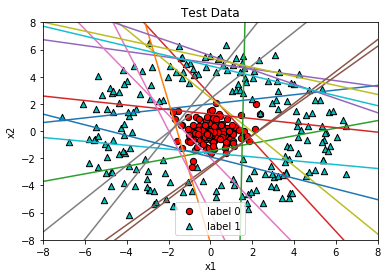

In [12]:
W = sess.run(W_fc1)
W.shape
b = sess.run(b_fc1)
x1 = np.linspace(-8,8,num=100)
for i in range(n_hid):
    x2 = (-b[i] - W[0,i]*x1)/(W[1,i])
    plt.plot(x1, x2)
plt.title("Test Data")
plt.xlabel('x1')
plt.scatter(test_set[:n_test,0], test_set[:n_test,1], c='r', \
            edgecolor='k', s=40, label='label 0')
plt.scatter(test_set[n_test:,0], test_set[n_test:,1], marker='^', \
            c='c', edgecolor='k', s=40, label='label 1')
plt.axis([-8,8,-8,8])
plt.ylabel('x2')
plt.legend(loc='best')
#plt.grid(True)
plt.show()

# Hyperparameters

1. Training with mini-batches didn't improve the overall performance of the classifier, also since the training dataset size is relatively small I did backpropagation based on the updates from the whole training dataset, which is also increasing the speed of training.

2. AdamOptimizer with initial learning rate of 0.01 which manually decaying learning rate lead to the best performance.

3. Training set size of 3000 (1500 samples from each class) brings regularization effect to the training, because its big enough to help classifier become robust enough for outliers, and validation set has size 300 and test set with size 400. 

4. Number of epochs was chosen as 2000 to prevent overfitting 

# Interpretations of the results

The training accuracy = 99.10% validation accuracy = 99.33% and test accuracy = 99.25%

We can see that sometimes validation accuracy is higher than the training one. It can be explained by two reasons:

1. Due to dropout and L2 regularization the parameters are specifically trained in a way to prevent overfitting on the training set. Without the regularization training accuracy can become much higher and lead to overfitting, but this is not what we want, we want our model to generalize well for an unseen data.

2. Some points from class 0 may appear in the region of class 1 due to the $r \sim N(0,1)$ and vice versa, and training set size is 10 times bigger than the validation set size, hence there is a possibility that the ratio of outliers is higher in the training set